In [1]:
from collections import namedtuple

import os
os.environ['DGLBACKEND'] = 'pytorch'
import dgl
from dgl.data.tree import SSTDataset


SSTBatch = namedtuple('SSTBatch', ['graph', 'mask', 'wordid', 'label'])

# Each sample in the dataset is a constituency tree. The leaf nodes
# represent words. The word is an int value stored in the "x" field.
# The non-leaf nodes have a special word PAD_WORD. The sentiment
# label is stored in the "y" feature field.
trainset = SSTDataset(mode='tiny')  # the "tiny" set has only five trees
tiny_sst = [tr for tr in trainset]
num_vocabs = trainset.vocab_size
num_classes = trainset.num_classes

vocab = trainset.vocab # vocabulary dict: key -> id
inv_vocab = {v: k for k, v in vocab.items()} # inverted vocabulary dict: id -> word

a_tree = tiny_sst[0]
for token in a_tree.ndata['x'].tolist():
    if token != trainset.PAD_WORD:
        print(inv_vocab[token], end=" ")

/opt/conda/envs/tactician/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


the rock is destined to be the 21st century 's new `` conan '' and that he 's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal . 

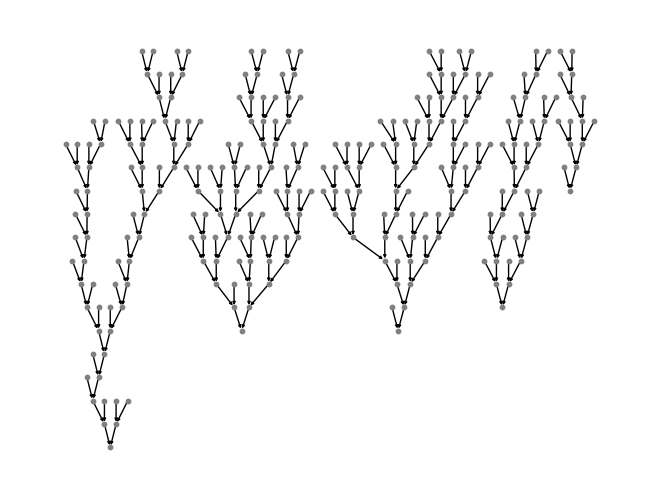

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

graph = dgl.batch(tiny_sst)
def plot_tree(g):
    # this plot requires pygraphviz package
    pos = nx.nx_agraph.graphviz_layout(g, prog='dot')
    nx.draw(g, pos, with_labels=False, node_size=10,
            node_color=[[.5, .5, .5]], arrowsize=4)
    plt.show()

plot_tree(graph.to_networkx())

In [4]:
import torch as th
import torch.nn as nn

class TreeLSTMCell(nn.Module):
    def __init__(self, x_size, h_size):
        super(TreeLSTMCell, self).__init__()
        self.W_iou = nn.Linear(x_size, 3 * h_size, bias=False)
        self.U_iou = nn.Linear(2 * h_size, 3 * h_size, bias=False)
        self.b_iou = nn.Parameter(th.zeros(1, 3 * h_size))
        self.U_f = nn.Linear(2 * h_size, 2 * h_size)

    def message_func(self, edges):
        return {'h': edges.src['h'], 'c': edges.src['c']}

    def reduce_func(self, nodes):
        # concatenate h_jl for equation (1), (2), (3), (4)
        h_cat = nodes.mailbox['h'].view(nodes.mailbox['h'].size(0), -1)
        # equation (2)
        f = th.sigmoid(self.U_f(h_cat)).view(*nodes.mailbox['h'].size())
        # second term of equation (5)
        c = th.sum(f * nodes.mailbox['c'], 1)
        return {'iou': self.U_iou(h_cat), 'c': c}

    def apply_node_func(self, nodes):
        # equation (1), (3), (4)
        iou = nodes.data['iou'] + self.b_iou
        i, o, u = th.chunk(iou, 3, 1)
        i, o, u = th.sigmoid(i), th.sigmoid(o), th.tanh(u)
        # equation (5)
        c = i * u + nodes.data['c']
        # equation (6)
        h = o * th.tanh(c)
        return {'h' : h, 'c' : c}

In [5]:
# to heterogenous graph
trv_a_tree = dgl.graph(a_tree.edges())
print('Traversing one tree:')
print(dgl.topological_nodes_generator(trv_a_tree))

# to heterogenous graph
trv_graph = dgl.graph(graph.edges())
print('Traversing many trees at the same time:')
print(dgl.topological_nodes_generator(trv_graph))

Traversing one tree:
(tensor([ 2,  3,  6,  8, 13, 15, 17, 19, 22, 23, 25, 27, 28, 29, 30, 32, 34, 36,
        38, 40, 43, 46, 47, 49, 50, 52, 58, 59, 60, 62, 64, 65, 66, 68, 69, 70]), tensor([ 1, 21, 26, 45, 48, 57, 63, 67]), tensor([24, 44, 56, 61]), tensor([20, 42, 55]), tensor([18, 54]), tensor([16, 53]), tensor([14, 51]), tensor([12, 41]), tensor([11, 39]), tensor([10, 37]), tensor([35]), tensor([33]), tensor([31]), tensor([9]), tensor([7]), tensor([5]), tensor([4]), tensor([0]))
Traversing many trees at the same time:
(tensor([  2,   3,   6,   8,  13,  15,  17,  19,  22,  23,  25,  27,  28,  29,
         30,  32,  34,  36,  38,  40,  43,  46,  47,  49,  50,  52,  58,  59,
         60,  62,  64,  65,  66,  68,  69,  70,  74,  76,  78,  79,  82,  83,
         85,  88,  90,  92,  93,  95,  96, 100, 102, 103, 105, 109, 110, 112,
        113, 117, 118, 119, 121, 125, 127, 129, 130, 132, 133, 135, 138, 140,
        141, 142, 143, 150, 152, 153, 155, 158, 159, 161, 162, 164, 168, 170,
  

In [6]:
import dgl.function as fn
import torch as th

trv_graph.ndata['a'] = th.ones(graph.number_of_nodes(), 1)
traversal_order = dgl.topological_nodes_generator(trv_graph)
trv_graph.prop_nodes(traversal_order,
                     message_func=fn.copy_u('a', 'a'),
                     reduce_func=fn.sum('a', 'a'))

# the following is a syntax sugar that does the same
# dgl.prop_nodes_topo(graph)

In [7]:
class TreeLSTM(nn.Module):
    def __init__(self,
                 num_vocabs,
                 x_size,
                 h_size,
                 num_classes,
                 dropout,
                 pretrained_emb=None):
        super(TreeLSTM, self).__init__()
        self.x_size = x_size
        self.embedding = nn.Embedding(num_vocabs, x_size)
        if pretrained_emb is not None:
            print('Using glove')
            self.embedding.weight.data.copy_(pretrained_emb)
            self.embedding.weight.requires_grad = True
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(h_size, num_classes)
        self.cell = TreeLSTMCell(x_size, h_size)

    def forward(self, batch, h, c):
        """Compute tree-lstm prediction given a batch.

        Parameters
        ----------
        batch : dgl.data.SSTBatch
            The data batch.
        h : Tensor
            Initial hidden state.
        c : Tensor
            Initial cell state.

        Returns
        -------
        logits : Tensor
            The prediction of each node.
        """
        g = batch.graph
        # to heterogenous graph
        g = dgl.graph(g.edges())
        # feed embedding
        embeds = self.embedding(batch.wordid * batch.mask)
        g.ndata['iou'] = self.cell.W_iou(self.dropout(embeds)) * batch.mask.float().unsqueeze(-1)
        g.ndata['h'] = h
        g.ndata['c'] = c
        # propagate
        dgl.prop_nodes_topo(g,
                            message_func=self.cell.message_func,
                            reduce_func=self.cell.reduce_func,
                            apply_node_func=self.cell.apply_node_func)
        # compute logits
        h = self.dropout(g.ndata.pop('h'))
        logits = self.linear(h)
        return logits

In [8]:
from torch.utils.data import DataLoader
import torch.nn.functional as F

device = th.device('cpu')
# hyper parameters
x_size = 256
h_size = 256
dropout = 0.5
lr = 0.05
weight_decay = 1e-4
epochs = 10

# create the model
model = TreeLSTM(trainset.vocab_size,
                 x_size,
                 h_size,
                 trainset.num_classes,
                 dropout)
print(model)

# create the optimizer
optimizer = th.optim.Adagrad(model.parameters(),
                          lr=lr,
                          weight_decay=weight_decay)

def batcher(dev):
    def batcher_dev(batch):
        batch_trees = dgl.batch(batch)
        return SSTBatch(graph=batch_trees,
                        mask=batch_trees.ndata['mask'].to(device),
                        wordid=batch_trees.ndata['x'].to(device),
                        label=batch_trees.ndata['y'].to(device))
    return batcher_dev

train_loader = DataLoader(dataset=tiny_sst,
                          batch_size=5,
                          collate_fn=batcher(device),
                          shuffle=False,
                          num_workers=0)

# training loop
for epoch in range(epochs):
    for step, batch in enumerate(train_loader):
        g = batch.graph
        n = g.number_of_nodes()
        h = th.zeros((n, h_size))
        c = th.zeros((n, h_size))
        logits = model(batch, h, c)
        logp = F.log_softmax(logits, 1)
        loss = F.nll_loss(logp, batch.label, reduction='sum')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pred = th.argmax(logits, 1)
        acc = float(th.sum(th.eq(batch.label, pred))) / len(batch.label)
        print("Epoch {:05d} | Step {:05d} | Loss {:.4f} | Acc {:.4f} |".format(
            epoch, step, loss.item(), acc))

TreeLSTM(
  (embedding): Embedding(19536, 256)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=256, out_features=5, bias=True)
  (cell): TreeLSTMCell(
    (W_iou): Linear(in_features=256, out_features=768, bias=False)
    (U_iou): Linear(in_features=512, out_features=768, bias=False)
    (U_f): Linear(in_features=512, out_features=512, bias=True)
  )
)


/opt/conda/envs/tactician/lib/python3.11/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(


Epoch 00000 | Step 00000 | Loss 444.4679 | Acc 0.1502 |
Epoch 00001 | Step 00000 | Loss 255.1752 | Acc 0.7436 |
Epoch 00002 | Step 00000 | Loss 967.2929 | Acc 0.3407 |
Epoch 00003 | Step 00000 | Loss 326.4951 | Acc 0.6117 |
Epoch 00004 | Step 00000 | Loss 186.0228 | Acc 0.8388 |
Epoch 00005 | Step 00000 | Loss 369.5124 | Acc 0.7289 |
Epoch 00006 | Step 00000 | Loss 155.1314 | Acc 0.8425 |
Epoch 00007 | Step 00000 | Loss 87.1402 | Acc 0.9121 |
Epoch 00008 | Step 00000 | Loss 62.7319 | Acc 0.9524 |
Epoch 00009 | Step 00000 | Loss 45.1761 | Acc 0.9597 |
